# Training Model 

In [35]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import average_precision_score, roc_auc_score


In [36]:
loans_train = pd.read_csv("data/feature_engineering/loans_train_processed.csv")
loans_test = pd.read_csv("data/feature_engineering/loans_test_processed.csv")
loans_valid = pd.read_csv("data/feature_engineering/loans_valid_processed.csv")

In [37]:
# 按 dtype 分组输出列名
# 将 dtype 转为字符串，方便作为分组键
_dtypes = loans_train.dtypes.astype(str)
_groups = {}
for _col, _dt in _dtypes.items():
    _groups.setdefault(_dt, []).append(_col)

for _dt, _cols in _groups.items():
    print(f"\n=== {_dt} ===")
    for _col in _cols:
        print(f"{_col:40s} {_dt}")


=== int64 ===
LoanID                                   int64
index                                    int64
target                                   int64
MI_Pct                                   int64
NumberOfUnits                            int64
OriginalCLTV                             int64
OriginalLTV                              int64
PostalCode                               int64
OriginalLoanTerm                         int64
NumberOfBorrowers                        int64
PropertyValMethod                        int64
FirstTimeHomebuyerFlag_N                 int64
FirstTimeHomebuyerFlag_Y                 int64
OccupancyStatus_I                        int64
OccupancyStatus_P                        int64
OccupancyStatus_S                        int64
Channel_B                                int64
Channel_C                                int64
Channel_R                                int64
PPM_Flag_N                               int64
ProductType_FRM                          int6

## training model preparation

In [38]:
X_train = loans_train.select_dtypes(include=[np.number]).drop(columns=["LoanID", "index", "target"], errors="ignore")
y_train = loans_train["target"]

## Baseline Model

***Random Forest***

In [39]:
# ============================================
# 3-Model Ensemble Baseline for Anomaly Detection
# Models: IsolationForest + PCA Reconstruction Error + LOF
# Outputs: validation metrics + submission.csv
# Requirements: loans_train, loans_valid, loans_test are loaded
# ============================================

import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor

# ----------------------------
# 0) Utilities
# ----------------------------
def select_numeric_features(df, drop_cols=None):
    drop_cols = drop_cols or []
    X = df.select_dtypes(include=[np.number]).drop(columns=drop_cols, errors="ignore")
    return X

def minmax_norm(x):
    x = np.asarray(x, dtype=float)
    xmin, xmax = np.nanmin(x), np.nanmax(x)
    if xmax == xmin:
        return np.zeros_like(x)  # all same -> return zeros
    return (x - xmin) / (x - xmin if False else (xmax - xmin))

def print_metrics(name, y_true, scores):
    auc = roc_auc_score(y_true, scores)
    ap  = average_precision_score(y_true, scores)
    print(f"{name:>24s} — ROC-AUC: {auc:.4f} | AP: {ap:.4f}")
    return auc, ap

# ----------------------------
# 1) Prepare data (numeric only)
# ----------------------------
# train/valid contain 'target'，test 只有 'Id'
X_train = select_numeric_features(loans_train, drop_cols=["index", "target"])
y_train = loans_train["target"].astype(int)

X_valid = select_numeric_features(loans_valid, drop_cols=["index", "target"])
y_valid = loans_valid["target"].astype(int)

X_test  = select_numeric_features(loans_test,  drop_cols=["Id"])
test_ids = loans_test["Id"].values

print(f"✅ Shapes -> Train: {X_train.shape}, Valid: {X_valid.shape}, Test: {X_test.shape}")

# 缺失统一填充（无监督模型 & 标准化需要）
X_train = X_train.fillna(0.0)
X_valid = X_valid.fillna(0.0)
X_test  = X_test.fillna(0.0)

# 标准化（fit on train, transform on valid/test）
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_valid_s = scaler.transform(X_valid)
X_test_s  = scaler.transform(X_test)

# ----------------------------
# 2) Model A: IsolationForest
# ----------------------------
iso = IsolationForest(
    n_estimators=400,
    contamination=0.05,   # 可按验证集异常比例微调，如 0.05 / 0.1
    max_samples=0.8,
    random_state=42,
    n_jobs=-1
)
iso.fit(X_train_s)

# 注意：decision_function 越大越“正常”，取负号让“越大越异常”
scores_iso_valid = -iso.decision_function(X_valid_s)
scores_iso_test  = -iso.decision_function(X_test_s)

print("\n📊 Validation metrics")
_ = print_metrics("IsolationForest", y_valid, scores_iso_valid)

# ----------------------------
# 3) Model B: PCA Reconstruction Error
# ----------------------------
# 用 95% 方差的主成分重构，重构误差越大越异常
pca = PCA(n_components=0.95, random_state=42)
X_train_p = pca.fit_transform(X_train_s)
X_valid_p = pca.transform(X_valid_s)
X_test_p  = pca.transform(X_test_s)

X_valid_recon = pca.inverse_transform(X_valid_p)
X_test_recon  = pca.inverse_transform(X_test_p)

recon_err_valid = np.mean((X_valid_s - X_valid_recon) ** 2, axis=1)
recon_err_test  = np.mean((X_test_s  - X_test_recon)  ** 2, axis=1)

_ = print_metrics("PCA_Reconstruction", y_valid, recon_err_valid)

# ----------------------------
# 4) Model C: Local Outlier Factor (novelty mode)
# ----------------------------
lof = LocalOutlierFactor(
    n_neighbors=20,
    novelty=True,      # 允许在 unseen data 上 predict
    contamination=0.05 # 与 IF 保持一致或微调
)
lof.fit(X_train_s)

# decision_function 越大越“正常”，取负号为“越大越异常”
scores_lof_valid = -lof.decision_function(X_valid_s)
scores_lof_test  = -lof.decision_function(X_test_s)

_ = print_metrics("LocalOutlierFactor", y_valid, scores_lof_valid)

# ----------------------------
# 5) Ensemble (Weighted Average)
# ----------------------------
# 先把三路分数各自归一化到 [0,1]，再加权平均
v_iso = minmax_norm(scores_iso_valid)
v_pca = minmax_norm(recon_err_valid)
v_lof = minmax_norm(scores_lof_valid)

t_iso = minmax_norm(scores_iso_test)
t_pca = minmax_norm(recon_err_test)
t_lof = minmax_norm(scores_lof_test)

# 融合权重（可微调）：IF权重稍高，PCA/LOF 辅助
w_iso, w_pca, w_lof = 0.4, 0.3, 0.3

valid_ens = w_iso * v_iso + w_pca * v_pca + w_lof * v_lof
test_ens  = w_iso * t_iso + w_pca * t_pca + w_lof * t_lof

print_metrics("Ensemble(ISO+PCA+LOF)", y_valid, valid_ens)

# ----------------------------
# 6) Make submission (Id, target in [0,1])
# ----------------------------
submission = pd.DataFrame({
    "Id": test_ids,
    "target": np.clip(test_ens, 0, 1)  # double safety
})
submission.to_csv("submission.csv", index=False)
print("\n✅ submission.csv saved! Preview:")
print(submission.head())


✅ Shapes -> Train: (30504, 136), Valid: (5370, 136), Test: (13426, 136)

📊 Validation metrics
         IsolationForest — ROC-AUC: 0.5384 | AP: 0.1315
      PCA_Reconstruction — ROC-AUC: 0.5759 | AP: 0.2010
      LocalOutlierFactor — ROC-AUC: 0.5906 | AP: 0.2194
   Ensemble(ISO+PCA+LOF) — ROC-AUC: 0.5448 | AP: 0.1426

✅ submission.csv saved! Preview:
   Id    target
0   0  0.072054
1   1  0.021491
2   2  0.041559
3   3  0.043728
4   4  0.068022


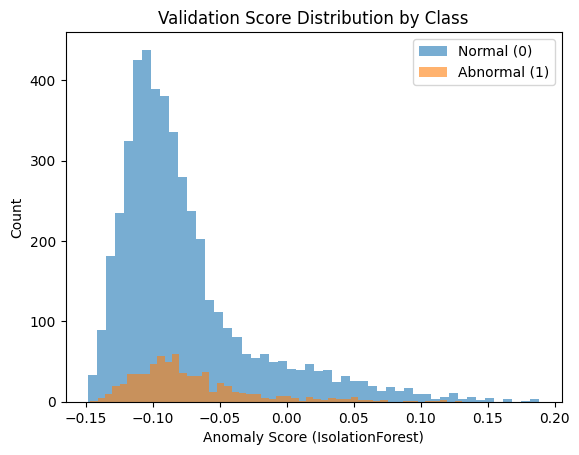

In [40]:
import matplotlib.pyplot as plt

plt.hist(valid_scores[y_valid==0], bins=50, alpha=0.6, label="Normal (0)")
plt.hist(valid_scores[y_valid==1], bins=50, alpha=0.6, label="Abnormal (1)")
plt.xlabel("Anomaly Score (IsolationForest)")
plt.ylabel("Count")
plt.legend()
plt.title("Validation Score Distribution by Class")
plt.show()
